In [1]:
from torch.utils.data import DataLoader 
import torch
import matplotlib.pyplot as plt
from pyscf import gto, dft, scf 
from kspies import wy, zmp
from dpyscfl.scf import *
from dpyscfl.net import *
from dpyscfl.utils import *
import os, shutil, copy
from ase import Atoms
from ase.units import Bohr, Hartree
import pickle

from ase.io import read, write
from torchviz import make_dot
import pylibnxc

In [3]:
ref = read('/home/awills/Documents/Research/swxcd/seawulf/g2_97_3/results.traj', ':')
xcdp = '/home/awills/Documents/Research/swxcd/eval/xcdiff/g2_97/preds_2'
xcdsf1 = '/home/awills/Documents/Research/swxcd/eval/xcdsymfrac/abfrac/swmg1/g2_97/preds_d2tzvpd'
xcdsf3 = '/home/awills/Documents/Research/swxcd/eval/xcdsymfrac/abfrac/swmg3/g2_97/preds_d2tzvpd'
#paths = [xcdp, xcdfp, RFP, FRP, FR1P, xcdcp]
paths = [xcdp, xcdsf1, xcdsf3]
es = {p:[] for p in paths}
ref_es = [at.calc.results['energy']/Hartree for at in ref]
for idx,atom in enumerate(ref):
    pckl = '{}_{}.pckl'.format(idx, atom.symbols)
    for key in list(es.keys()):
        if idx == 0:
            print(key)
        with open(key+'/{}'.format(pckl), 'rb') as f:
            e = pickle.load(f)
        es[key].append(e['E'])

n_atoms = [len(at.positions) for at in ref]
def mse(ref_es, pred_es, n_atoms):
    err = []
    for idx in range(len(ref_es)):
        ref = ref_es[idx]
        pred = pred_es[idx]
        nat = n_atoms[idx]
        err.append((ref-pred)**2)
    mse = np.mean(err)
    std = np.std(err)
    return ([np.sqrt(ierr) for ierr in err], mse, std)

/home/awills/Documents/Research/swxcd/eval/xcdiff/g2_97/preds_2
/home/awills/Documents/Research/swxcd/eval/xcdsymfrac/abfrac/swmg1/g2_97/preds_d2tzvpd
/home/awills/Documents/Research/swxcd/eval/xcdsymfrac/abfrac/swmg3/g2_97/preds_d2tzvpd


In [5]:
errd = {key: mse(ref_es, val, n_atoms) for key,val in es.items()}
labels = {xcdp: 'XCDiff',
         xcdsf1: 'XCDiff+F (Full Net, Grid 1)',
       xcdsf3: 'XCDiff+F (Full Net, Grid 3)',}

/home/awills/Documents/Research/swxcd/eval/xcdiff/g2_97/preds_2 0.003096511376351026
/home/awills/Documents/Research/swxcd/eval/xcdsymfrac/abfrac/swmg1/g2_97/preds_d2tzvpd 0.19018296876037788
/home/awills/Documents/Research/swxcd/eval/xcdsymfrac/abfrac/swmg3/g2_97/preds_d2tzvpd 0.18462852436073243


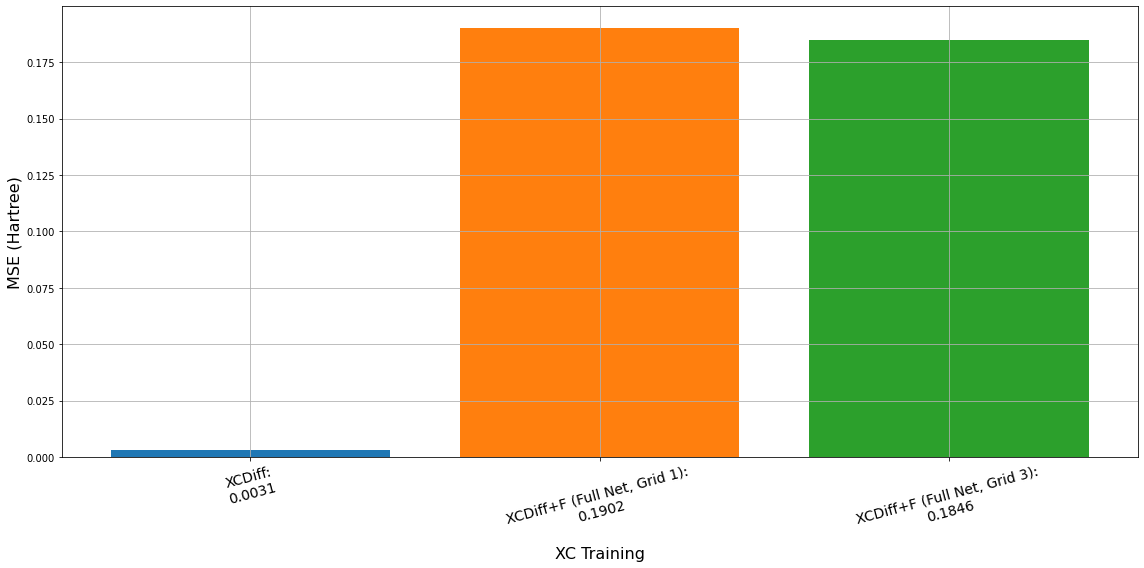

In [7]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(111)
count = 1
xtlabs = []
ax.grid()
for k,v in errd.items():
    print(k, v[1])
    lab = labels[k]+':\n{:3.4f}'.format(v[1])
    ax.bar(count, v[1], label=lab)
    xtlabs.append(lab)
    count += 1
ax.set_xticks(np.arange(1, count))
ax.set_xticklabels(xtlabs, fontsize=14, rotation=15)
ax.set_ylabel("MSE (Hartree)", fontsize=16)
ax.set_xlabel("XC Training", fontsize=16)
plt.tight_layout()

<BarContainer object of 148 artists>

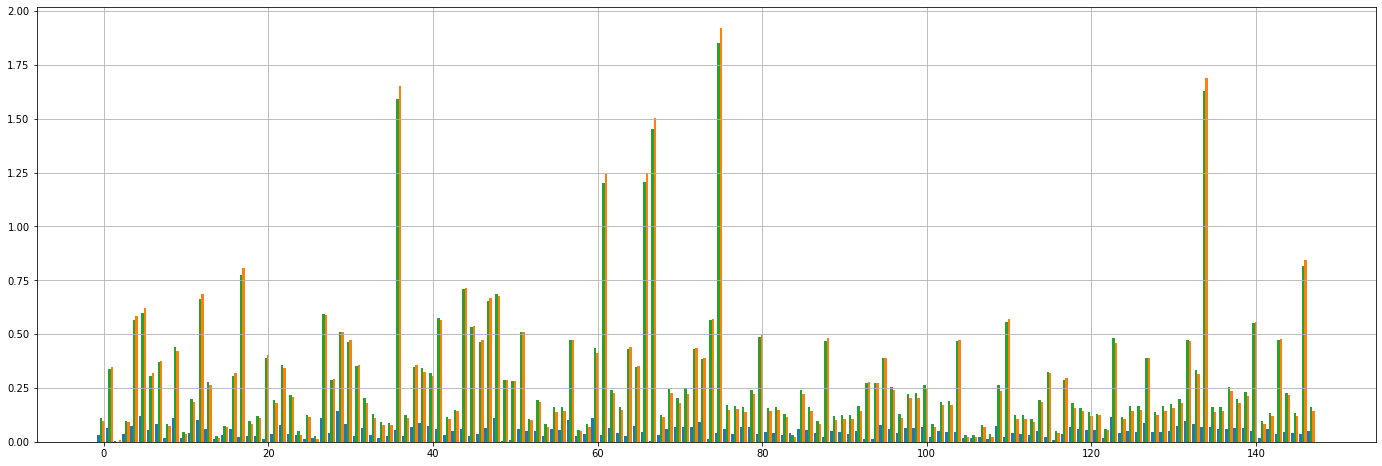

In [13]:
f = plt.figure(figsize=(24,8))
ax = f.add_subplot(111)
ax.grid()
def gen_xs_bar(*args, **kwargs):
    midsep = kwargs.get('midsep', 1)
    width = kwargs.get('width', midsep/(len(args)+2))
    xs = []
    start = -len(args)//2
    for iarg in range(len(args)):
        arg = args[iarg]
        argxs = []
        for igroup in range(len(arg)):
            argxs.append(igroup*midsep+start*width)
        start += 1
        xs.append(argxs)
    return xs
xcdx, xcdfx, xcdfgx = gen_xs_bar(errd[paths[0]][0], errd[paths[1]][0], errd[paths[2]][0], width=0.3)
ax.bar(xcdx, errd[paths[0]][0], width=0.3)
ax.bar(xcdfgx, errd[paths[1]][0], width=0.3)
ax.bar(xcdfx, errd[paths[2]][0], width=0.3)

In [10]:
errd[paths[0]]

([0.033024390411583227,
  0.06352721205666967,
  0.001816728044988114,
  0.03449467049847499,
  0.07534177868819825,
  0.12145634673458972,
  0.053288276981732,
  0.08238225696709378,
  0.017592864355364668,
  0.1085491915818011,
  0.017542979648240475,
  0.04089629470854561,
  0.10168318820592503,
  0.059368552119906326,
  0.011947120106921005,
  0.031484310921754854,
  0.05794320129348307,
  0.020891515639277713,
  0.02586239439992255,
  0.024917440585014106,
  0.014429990872145027,
  0.034428282704368485,
  0.07750456030356645,
  0.03514334042441192,
  0.033644233078124586,
  0.011075765269595195,
  0.0180742767109745,
  0.10827712206810247,
  0.040990378689571116,
  0.14201828367322378,
  0.08317510962865526,
  0.02869657269320669,
  0.0655354331422302,
  0.032988373406467986,
  0.017607691662320235,
  0.024617463776479553,
  0.0549203966636469,
  0.028392551440589386,
  0.06715987120560385,
  0.08534895653792773,
  0.07505949333267381,
  0.059138653565696586,
  0.03257715214297718